Предложи систему, которая позволит по кропу области с произвольным логотипом на изображении (берется из видео, куда нативно встроена реклама) отвечать на вопрос: "Является ли он логотипом искомой организации?".

В качестве логотипов искомой организации дается несколько образцов. Заранее неизвестно, что именно эта организация будет искаться. Логотипы могут быть текстовыми и нетекстовыми.

На изображении в реальности данные логотипы могут иметь самый различный масштаб, могут иметь отличные характеристики по яркости, контрастности, могут быть повернуты, несколько искажены, иметь небольшие отличия в дизайне.

Если получится, продемонстрируй работу системы на примерах.

Из open source датасетов есть такой вариант https://paperswithcode.com/dataset/logodet-3k, если будет полезно.

В виде ответа дай описание системы и, если есть прототип, приложи ссылку на код с примерами в репозитории на GitHub, GitLab, Bitbucket или любой другой с открытым доступом.

In [1]:
! pip install tqdm

In [2]:
# Монтируем Google Drive
import shutil, os
from google.colab import drive

# Проверяем и очищаем точку монтирования
mount_point = '/content/drive'
if os.path.exists(mount_point):
    try:
        # Размонтируем, если уже примонтировано
        !fusermount -u {mount_point}
    except:
        pass
    # Очищаем директорию
    shutil.rmtree(mount_point)

# Создаем чистую директорию для монтирования
os.makedirs(mount_point, exist_ok=True)

# Монтируем Google Drive
drive.mount(mount_point)

Mounted at /content/drive


In [3]:
!pip uninstall -y torch torchvision torchaudio tensorflow tensorflow-cpu
!pip install --upgrade pip
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0


Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
Found existing installation: torchaudio 2.5.1+cu124
Uninstalling torchaudio-2.5.1+cu124:
  Successfully uninstalled torchaudio-2.5.1+cu124
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.18 requires torch<2.6,>=1.10, which is not installed.
fastai 2

In [4]:
!pip install cloud-tpu-client==0.10 torch==2.1.0 torch_xla[tpu]>=2.1.0 -f https://storage.googleapis.com/libtpu-releases/index.html


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-storage 2.19.0 requires google-api-core<3.0.0dev,>=2.15.0, but you have google-api-core 1.34.1 which is incompatible.
pydrive2 1.21.3 requires google-api-python-client>=1.12.5, but you have google-api-python-client 1.8.0 which is incompatible.
earthengine-api 1.4.6 requires google-api-python-client>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.
google-cloud-bigtable 2.28.1 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_versio

In [5]:
# Установка PyTorch XLA
!pip install cloud-tpu-client==0.10
!pip install torch==2.1.0
!pip install torch_xla[tpu] -f https://storage.googleapis.com/libtpu-releases/index.html

Looking in links: https://storage.googleapis.com/libtpu-releases/index.html


In [6]:
# Импортируем необходимые библиотеки
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os
import random
from tqdm import tqdm
import tarfile
import matplotlib.pyplot as plt
import numpy as np

# Проверяем доступность TPU
USE_TPU = False
if os.environ.get('COLAB_TPU_ADDR'):
    try:
        import torch_xla
        import torch_xla.core.xla_model as xm
        import torch_xla.distributed.parallel_loader as pl
        import torch_xla.distributed.xla_multiprocessing as xmp
        USE_TPU = True
        print('TPU available')
    except ImportError:
        print('Failed to import torch_xla')

# Определяем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if USE_TPU:
    device = xm.xla_device()
print(f"Using device: {device}")

# Константы
DATASET_TAR = '/content/drive/MyDrive/openlogo.tar'
EXTRACT_PATH = '/content/openlogo_dataset'
MODEL_SAVE_PATH = '/content/drive/MyDrive/logo_model'

# Создаем директорию для сохранения моделей
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

Using device: cpu


In [7]:
class OpenLogo:
    def __init__(self, root_dir: str):
        self.root_dir = os.path.join(root_dir, 'openlogo')
        self.images_dir = os.path.join(self.root_dir, 'JPEGImages')
        self.imagesets_dir = os.path.join(self.root_dir, 'ImageSets', 'Main', 'train_test')

        self.train_images = self._load_image_list('train_all.txt')
        self.test_images = self._load_image_list('test_all.txt')
        self.classes = self._get_unique_classes()
        print(f"Found {len(self.classes)} classes")
        self._verify_images()

    def _verify_images(self):
        print("Verifying image files...")
        sample_image = self.train_images[0]
        sample_path = os.path.join(self.images_dir, f"{sample_image}.jpg")
        print(f"Sample image path: {sample_path}")
        print(f"Image exists: {os.path.exists(sample_path)}")
        print(f"Directory contents: {os.listdir(self.images_dir)[:5]}")

    def _load_image_list(self, filename: str) -> list:
        image_list = []
        filepath = os.path.join(self.imagesets_dir, filename)
        print(f"Loading {filepath}")

        with open(filepath, 'r') as f:
            for line in f:
                image_id = line.strip()
                if image_id:
                    image_list.append(image_id)
        print(f"Loaded {len(image_list)} images from {filename}")
        return image_list

    def _get_unique_classes(self) -> set:
        classes = set()
        for img_id in self.train_images + self.test_images:
            if '_' in img_id:
                class_name = img_id.split('_')[0]
                classes.add(class_name)
            else:
                print(f"Warning: Unexpected image ID format: {img_id}")
        return classes

    def get_logo_pairs(self, num_pairs: int) -> list:
        pairs = []
        class_to_images = {}
        for img_id in self.train_images:
            if '_' in img_id:
                class_name = img_id.split('_')[0]
                if class_name not in class_to_images:
                    class_to_images[class_name] = []
                class_to_images[class_name].append(img_id)

        for _ in tqdm(range(num_pairs), desc="Generating pairs"):
            if random.random() > 0.5:
                class_name = random.choice(list(class_to_images.keys()))
                if len(class_to_images[class_name]) < 2:
                    continue

                img1_id, img2_id = random.sample(class_to_images[class_name], 2)
                pairs.append((
                    os.path.join(self.images_dir, f"{img1_id}.jpg"),
                    os.path.join(self.images_dir, f"{img2_id}.jpg"),
                    1
                ))
            else:
                class1, class2 = random.sample(list(class_to_images.keys()), 2)
                img1_id = random.choice(class_to_images[class1])
                img2_id = random.choice(class_to_images[class2])
                pairs.append((
                    os.path.join(self.images_dir, f"{img1_id}.jpg"),
                    os.path.join(self.images_dir, f"{img2_id}.jpg"),
                    0
                ))
        return pairs

class LogoDataset(Dataset):
    def __init__(self, logo_pairs, transform=None):
        self.logo_pairs = logo_pairs
        self.transform = transform

    def __len__(self):
        return len(self.logo_pairs)

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.logo_pairs[idx]

        try:
            img1 = Image.open(img1_path).convert('RGB')
            img2 = Image.open(img2_path).convert('RGB')
        except Exception as e:
            print(f"Error loading images: {e}")
            return self.__getitem__(random.randint(0, len(self) - 1))

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Загружаем предобученную ResNet50
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

        # Удаляем последний слой классификации
        modules = list(resnet.children())[:-1]
        self.feature_extractor = nn.Sequential(*modules)

        # Добавляем свои слои для сравнения признаков
        self.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )

        # Замораживаем веса ResNet
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward_one(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        return self.fc(features)

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        return F.cosine_similarity(out1, out2)

def load_checkpoint(model, optimizer=None, filename='best_model.pth'):
    """
    Загрузка сохраненной модели и оптимизатора
    """
    try:
        checkpoint = torch.load(filename, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        if optimizer is not None and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint.get('epoch', -1)
        loss = checkpoint.get('loss', float('inf'))
        print(f"Checkpoint loaded: epoch {epoch}, loss {loss:.4f}")
        return epoch, loss
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        return -1, float('inf')

def create_data_loaders(dataset_path: str, num_pairs: int, batch_size: int):
    print(f"Initializing dataset from {dataset_path}")

    dataset = OpenLogo(dataset_path)

    all_pairs = dataset.get_logo_pairs(num_pairs)
    train_size = int(0.8 * len(all_pairs))

    train_pairs = all_pairs[:train_size]
    val_pairs = all_pairs[train_size:]

    print(f"Created {len(train_pairs)} training pairs and {len(val_pairs)} validation pairs")

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    train_dataset = LogoDataset(train_pairs, transform=transform)
    val_dataset = LogoDataset(val_pairs, transform=transform)

    train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2)
    val_loader = DataLoader(val_dataset,
                           batch_size=batch_size,
                           shuffle=False,
                           num_workers=2)

    return train_loader, val_loader

def save_checkpoint(model, optimizer, epoch, loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    if USE_TPU:
        xm.save(checkpoint, filename)
    else:
        torch.save(checkpoint, filename)
    print(f"Checkpoint saved: {filename}")

In [9]:
def train_model(model, train_loader, val_loader, epochs=10, continue_training=False):
    """
    Обучение модели с возможностью продолжения обучения
    """
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

    start_epoch = 0
    best_val_loss = float('inf')

    # Загружаем сохраненную модель, если нужно продолжить обучение
    if continue_training:
        best_model_path = os.path.join(MODEL_SAVE_PATH, 'best_model.pth')
        if os.path.exists(best_model_path):
            last_epoch, best_val_loss = load_checkpoint(model, optimizer, best_model_path)
            start_epoch = last_epoch + 1
            print(f"Continuing training from epoch {start_epoch}")
        else:
            print("No checkpoint found, starting from scratch")

    model = model.to(device)

    for epoch in range(start_epoch, start_epoch + epochs):
        # Обучение
        model.train()
        train_loss = 0

        for batch_idx, (img1, img2, label) in enumerate(train_loader):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            optimizer.zero_grad()
            output = model(img1, img2)
            loss = criterion(output, label)
            loss.backward()

            if USE_TPU:
                xm.optimizer_step(optimizer)
            else:
                optimizer.step()

            train_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')

        avg_train_loss = train_loss / len(train_loader)

        # Валидация
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for img1, img2, label in val_loader:
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)
                output = model(img1, img2)
                val_loss += criterion(output, label).item()

                pred = (output > 0.5).float()
                correct += (pred == label).sum().item()
                total += label.size(0)

        avg_val_loss = val_loss / len(val_loader)
        accuracy = correct / total

        print(f'Epoch {epoch}:')
        print(f'Average train loss: {avg_train_loss:.4f}')
        print(f'Average validation loss: {avg_val_loss:.4f}')
        print(f'Validation accuracy: {accuracy:.4f}')

        # Сохраняем чекпоинт для каждой эпохи
        checkpoint_path = os.path.join(MODEL_SAVE_PATH, f'checkpoint_epoch_{epoch}.pth')
        save_checkpoint(model, optimizer, epoch, avg_val_loss, checkpoint_path)

        # Сохраняем лучшую модель
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_path = os.path.join(MODEL_SAVE_PATH, 'best_model.pth')
            save_checkpoint(model, optimizer, epoch, best_val_loss, best_model_path)
            print(f"New best model saved with validation loss: {best_val_loss:.4f}")

def load_and_preprocess_image(image_path):
    """
    Загрузка и предобработка изображения
    """
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

def detect_logo(model, reference_logo_path, test_image_path, threshold=0.7):
    """
    Определение схожести логотипов
    """
    reference_logo = load_and_preprocess_image(reference_logo_path)
    test_image = load_and_preprocess_image(test_image_path)

    model.eval()

    with torch.no_grad():
        reference_logo = reference_logo.to(device)
        test_image = test_image.to(device)
        similarity = model(reference_logo, test_image)
        similarity_score = similarity.item()

    return similarity_score > threshold, similarity_score

def visualize_comparison(reference_logo_path, test_image_path, similarity_score):
    """
    Визуализация результатов сравнения
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ref_img = Image.open(reference_logo_path)
    test_img = Image.open(test_image_path)

    ax1.imshow(ref_img)
    ax1.set_title('Reference Logo')
    ax1.axis('off')

    ax2.imshow(test_img)
    ax2.set_title(f'Test Image\nSimilarity: {similarity_score:.3f}')
    ax2.axis('off')

    plt.show()

In [10]:
def test_model():
    """
    Функция для тестирования обученной модели
    """
    # Загружаем обученную модель
    model = SiameseNetwork().to(device)
    best_model_path = os.path.join(MODEL_SAVE_PATH, 'best_model.pth')

    if os.path.exists(best_model_path):
        checkpoint = torch.load(best_model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Model loaded successfully")
    else:
        print("No saved model found!")
        return

    # Загружаем тестовые изображения
    from google.colab import files
    print("Upload reference logo:")
    uploaded = files.upload()
    reference_logo_path = list(uploaded.keys())[0]

    print("\nUpload test images:")
    uploaded = files.upload()
    test_images = list(uploaded.keys())

    # Тестируем каждое изображение
    for test_image_path in test_images:
        is_match, similarity_score = detect_logo(model, reference_logo_path, test_image_path)
        print(f"\nTesting: {test_image_path}")
        print(f"Similarity score: {similarity_score:.3f}")
        print(f"Match: {is_match}")
        visualize_comparison(reference_logo_path, test_image_path, similarity_score)

def main(continue_training=False):
    """
    Основная функция для обучения модели

    Args:
        continue_training (bool): Продолжить обучение с сохраненной модели
    """
    # Распаковываем датасет
    if not os.path.exists(EXTRACT_PATH):
        print("Extracting dataset...")
        with tarfile.open(DATASET_TAR, 'r') as tar_ref:
            tar_ref.extractall(EXTRACT_PATH)
        print("Dataset extracted successfully")

    # Параметры обучения
    num_pairs = 5000
    batch_size = 16
    epochs = 5

    try:
        # Создаем загрузчики данных
        train_loader, val_loader = create_data_loaders(
            EXTRACT_PATH, num_pairs, batch_size
        )

        # Создаем модель
        model = SiameseNetwork()
        print("Model created with pretrained ResNet50")

        # Выводим информацию о параметрах модели
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

        # Обучаем модель
        train_model(model, train_loader, val_loader, epochs, continue_training)

    except Exception as e:
        print(f"Error occurred: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    # Для обучения с нуля
    # main(continue_training=False)

    # Для продолжения обучения с сохраненной модели
    main(continue_training=True)

    # Для тестирования модели раскомментируйте:
    # test_model()

Выходные данные были обрезаны до нескольких последних строк (5000).
Found 23 classes
Verifying image files...
Sample image path: /content/openlogo_dataset/openlogo/JPEGImages/3m10.jpg
Image exists: True
Directory contents: ['logos32plus_006642.jpg', 'starbucksimg000111.jpg', 'cartierimg000174.jpg', '5118357083.jpg', 'HH41.jpg']


Generating pairs: 100%|██████████| 5000/5000 [00:00<00:00, 24456.73it/s]


Created 4000 training pairs and 1000 validation pairs


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]


Model created with pretrained ResNet50
Total parameters: 24,622,784
Trainable parameters: 1,114,752
Checkpoint loaded: epoch 4, loss 0.5911
Continuing training from epoch 5
Epoch: 5, Batch: 0, Loss: 0.5438665151596069
Epoch: 5, Batch: 100, Loss: 0.5210517644882202
Epoch: 5, Batch: 200, Loss: 0.5880824327468872
Epoch 5:
Average train loss: 0.5735
Average validation loss: 0.5735
Validation accuracy: 0.8040
Checkpoint saved: /content/drive/MyDrive/logo_model/checkpoint_epoch_5.pth
Checkpoint saved: /content/drive/MyDrive/logo_model/best_model.pth
New best model saved with validation loss: 0.5735
Epoch: 6, Batch: 0, Loss: 0.5075497031211853
Epoch: 6, Batch: 100, Loss: 0.5808670520782471
Epoch: 6, Batch: 200, Loss: 0.4957547187805176
Epoch 6:
Average train loss: 0.5439
Average validation loss: 0.5677
Validation accuracy: 0.8220
Checkpoint saved: /content/drive/MyDrive/logo_model/checkpoint_epoch_6.pth
Checkpoint saved: /content/drive/MyDrive/logo_model/best_model.pth
New best model saved wi

Model loaded successfully
Upload reference logo:


Saving Icon.png to Icon.png

Upload test images:


Saving 3m.jpg to 3m (2).jpg
Saving abus.jpg to abus (2).jpg
Saving accenture.jpg to accenture (4).jpg
Saving adidas.jpg to adidas (2).jpg
Saving adidas_text.jpg to adidas_text (2).jpg
Saving adidas1.jpg to adidas1 (2).jpg
Saving airhawk.jpg to airhawk (2).jpg
Saving airness.jpg to airness (2).jpg
Saving aldi.jpg to aldi (2).jpg
Saving aldi_text.jpg to aldi_text (1).jpg

Testing: 3m (2).jpg
Similarity score: -0.035
Match: False


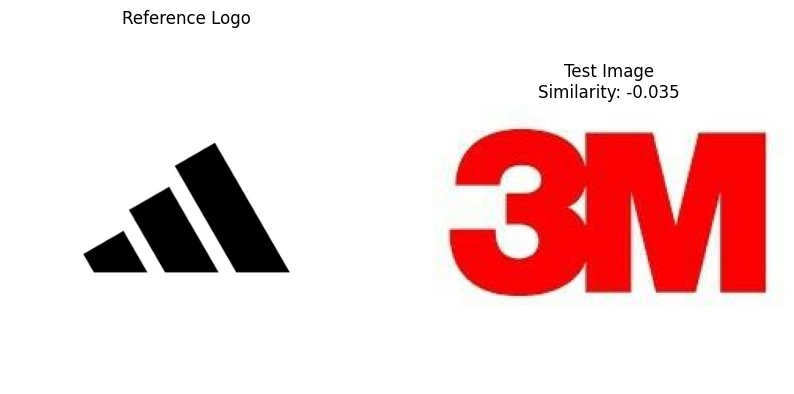


Testing: abus (2).jpg
Similarity score: 0.426
Match: False


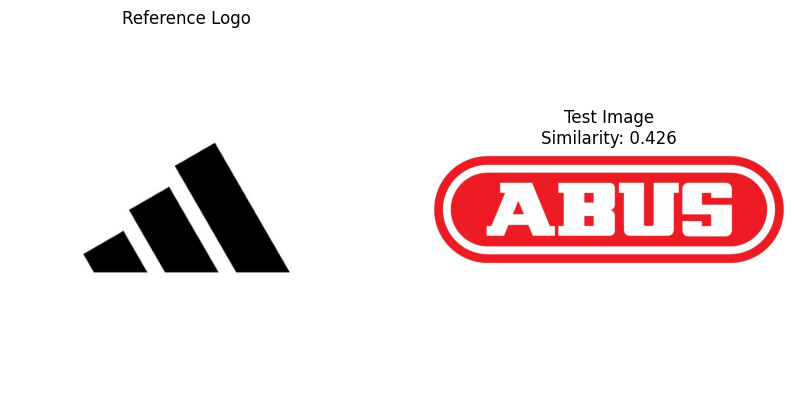


Testing: accenture (4).jpg
Similarity score: -0.065
Match: False


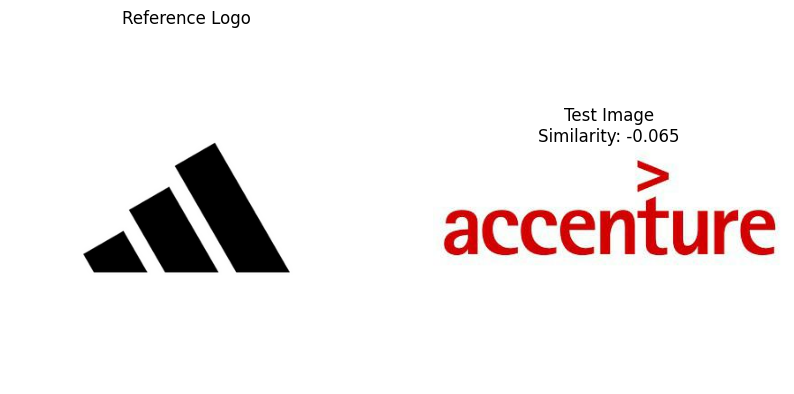


Testing: adidas (2).jpg
Similarity score: 0.574
Match: False


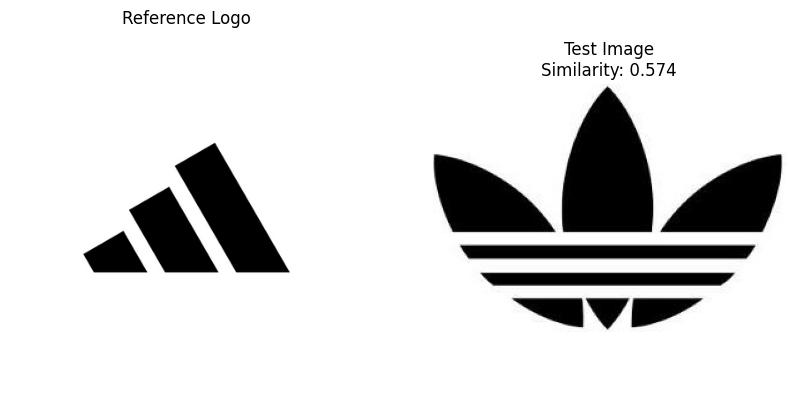


Testing: adidas_text (2).jpg
Similarity score: 0.235
Match: False


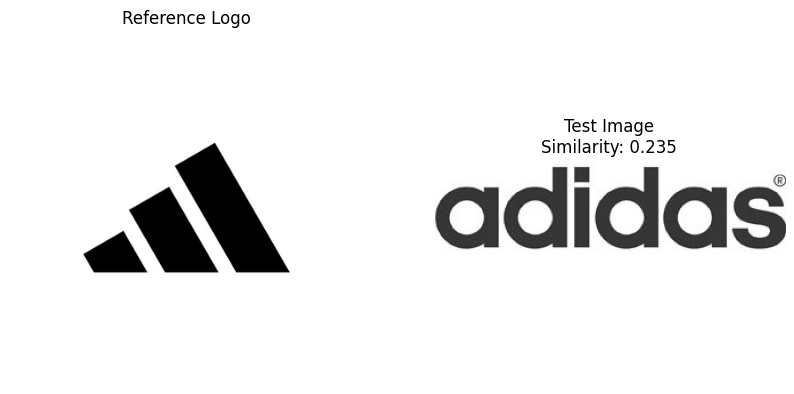


Testing: adidas1 (2).jpg
Similarity score: 0.538
Match: False


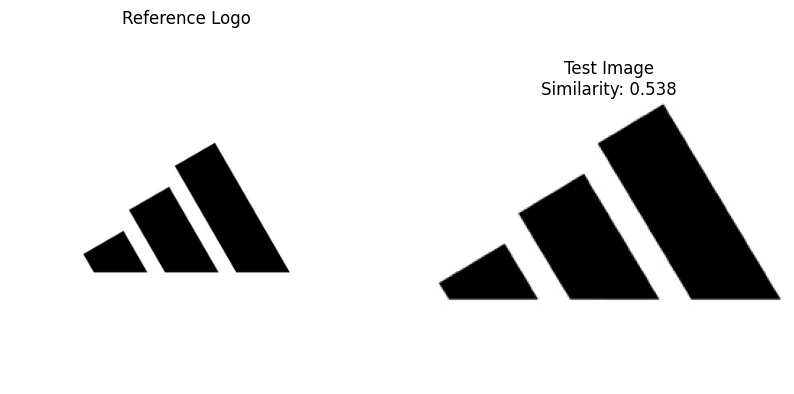


Testing: airhawk (2).jpg
Similarity score: 0.351
Match: False


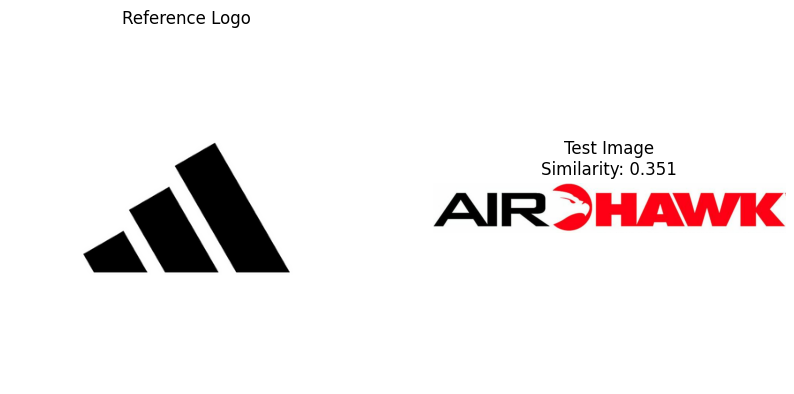


Testing: airness (2).jpg
Similarity score: 0.235
Match: False


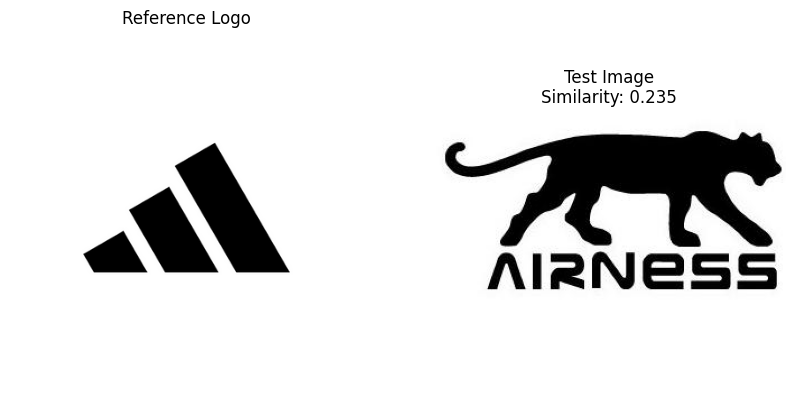


Testing: aldi (2).jpg
Similarity score: 0.527
Match: False


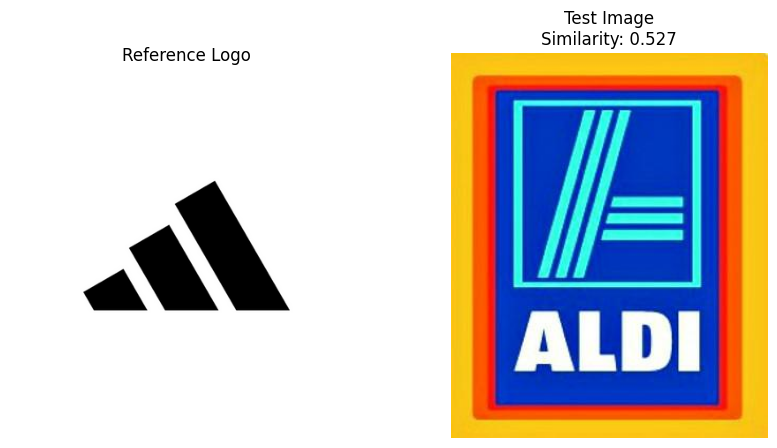


Testing: aldi_text (1).jpg
Similarity score: -0.486
Match: False


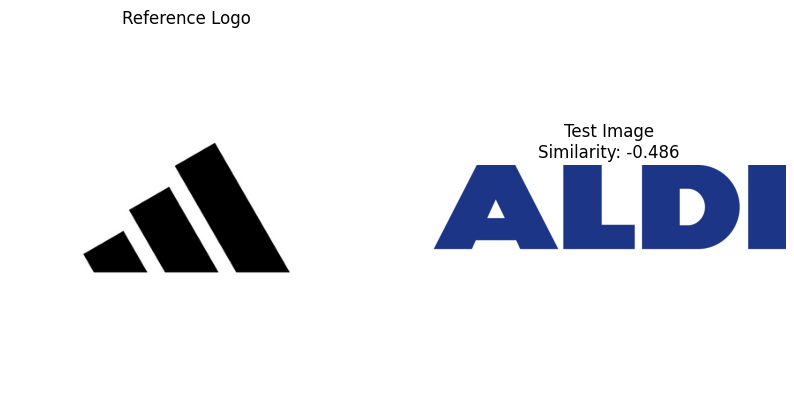

In [16]:
from google.colab import files
import io

def upload_images():
    """Загрузка изображений через интерфейс Colab"""
    uploaded = files.upload()
    image_paths = {}

    for filename in uploaded.keys():
        # Сохраняем загруженные файлы
        with open(filename, 'wb') as f:
            f.write(uploaded[filename])
        image_paths[filename] = filename

    return image_paths

def main_colab():
    """
    Интерактивное тестирование модели в Colab
    """
    # Загружаем модель
    model = SiameseNetwork().to(device)
    best_model_path = os.path.join(MODEL_SAVE_PATH, 'best_model.pth')

    if os.path.exists(best_model_path):
        checkpoint = torch.load(best_model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Model loaded successfully")
    else:
        print("No saved model found!")
        return

    try:
        # Загружаем эталонный логотип
        print("Upload reference logo:")
        reference_paths = upload_images()
        if not reference_paths:
            print("No reference logo uploaded!")
            return
        reference_logo_path = list(reference_paths.values())[0]

        # Загружаем тестовые изображения
        print("\nUpload test images:")
        test_paths = upload_images()
        if not test_paths:
            print("No test images uploaded!")
            return
        test_images = list(test_paths.values())

        # Тестируем каждое изображение
        for test_image_path in test_images:
            is_match, similarity_score = detect_logo(model, reference_logo_path, test_image_path)
            print(f"\nTesting: {test_image_path}")
            print(f"Similarity score: {similarity_score:.3f}")
            print(f"Match: {is_match}")
            visualize_comparison(reference_logo_path, test_image_path, similarity_score)

    except Exception as e:
        print(f"Error during testing: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    # Выберите нужный режим:

    # 1. Для обучения с нуля:
    # main(continue_training=False)

    # 2. Для продолжения обучения:
    # main(continue_training=True)

    # 3. Для интерактивного тестирования:
    main_colab()

#Документация системы распознавания логотипов

##1. Общее описание
Система представляет собой решение для сравнения и распознавания логотипов с использованием сиамской нейронной сети на базе предобученной ResNet50 и тренировочного датасета OpenLogo https://hangsu0730.github.io/qmul-openlogo/. Система способна определять схожесть между парами логотипов и может быть использована для:

Поиска схожих логотипов
Верификации логотипов
Детектирования логотипов в изображениях
Ключевые особенности:
Использование Transfer Learning (ResNet50)
Поддержка TPU/GPU/CPU
Сохранение промежуточных результатов
Визуализация результатов сравнения
Гибкая настройка параметров
##2. Архитектура системы
###2.1 Основные компоненты:
├── Предобработка данных

│  ├── OpenLogo (класс работы с датасетом)

│  └── LogoDataset (класс загрузки данных)

├── Модель

│  ├── SiameseNetwork (архитектура сети)

│  └── ResNet50 (базовая модель)

├── Обучение

│  ├── train_model (основная функция обучения)

│  └── save_checkpoint (сохранение весов)

└── Тестирование

   ├── detect_logo (детектирование)

   └── visualize_comparison (визуализация)

##2.2 Схема работы:
Входные данные -> Предобработка -> Сиамская сеть -> Оценка схожести -> Результат

#4. Процесс обучения
##4.1 Параметры обучения


In [ ]:
# Основные параметры
num_pairs = 5000  # Количество пар для обучения
batch_size = 16   # Размер батча
epochs = 5       # Количество эпох
learning_rate = 0.0001  # Скорость обучения

#5. Примеры использования
##5.1 Обучение модели

In [ ]:
# Создание модели и загрузчиков данных
model = SiameseNetwork()
train_loader, val_loader = create_data_loaders(EXTRACT_PATH, num_pairs=5000, batch_size=16)

# Обучение
train_model(model, train_loader, val_loader, epochs=10)

##5.2 Тестирование модели

In [ ]:
# Загрузка обученной модели
model = SiameseNetwork().to(device)
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Тестирование
is_match, score = detect_logo(model, 'reference.jpg', 'test.jpg')
visualize_comparison('reference.jpg', 'test.jpg', score)

##5.3 Интерактивное тестирование в Colab

In [ ]:
def test_model():
    # Загрузка модели
    model = SiameseNetwork().to(device)
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    # Загрузка изображений через интерфейс Colab
    from google.colab import files
    uploaded = files.upload()

    # Тестирование
    for test_image in uploaded:
        is_match, score = detect_logo(model, 'reference.jpg', test_image)
        visualize_comparison('reference.jpg', test_image, score)